In [196]:
import pandas as pd
import re
import datetime
import numpy as np
import os
from tqdm.auto import tqdm
from IPython.display import display as d
import matplotlib.pyplot as plt

In [197]:
# Helper Functions
def counts_and_perc(
    df: pd.core.frame.DataFrame, x: str, count="Counts", perc="Percentage %"
) -> pd.core.frame.DataFrame:
    """Given a pandas df and a column x in it, return the value counts summary
      with both counts and percentage
    Parameters
    ----------
    df : pd.DataFrame
    x : str
        Column to compute counts for, contained in the dataframe df
    count : str
        Name for the count column
    perc : str
        Name for the percentage column

    Returns
    -------
    pd.DataFrame with counts and ratio of counts
    """
    if x not in df.columns:
        raise Exception(f"The dataframe does not contain the column {x}")
    counts_df = df[x].value_counts(dropna=False).to_frame(name=count)
    counts_df = (
        counts_df.merge(
            (df[x].value_counts(normalize=True, dropna=False) * 100)
            .round(4)
            .to_frame(name=perc),
            left_index=True,
            right_index=True,
        )
        .reset_index()
        .rename(columns={"index": x})
    )
    return counts_df

In [198]:
# Read in the parquet file
retail = pd.read_parquet('retail_data.parquet')

### Univariate Analysis

Look at individual columns

**Invoice number**  
A 6-digit integral number is uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

In [199]:
counts_and_perc(retail, 'Invoice')

,Invoice,Counts,Percentage %
0,537434,1350,0.1265
1,538071,1304,0.1222
2,537638,1202,0.1126
3,537237,1194,0.1119
4,536876,1186,0.1111
...,...,...,...
53623,C518262,1,0.0001
53624,548515,1,0.0001
53625,C548513,1,0.0001
53626,C524395,1,0.0001


In [200]:
# Add Feature
# Cancellations start with a C
retail['IsCancellation'] = retail['Invoice'].str.contains('C.*', regex=True)

In [201]:
counts_and_perc(retail, 'IsCancellation')

,IsCancellation,Counts,Percentage %
0,False,1047877,98.1736
1,True,19494,1.8264


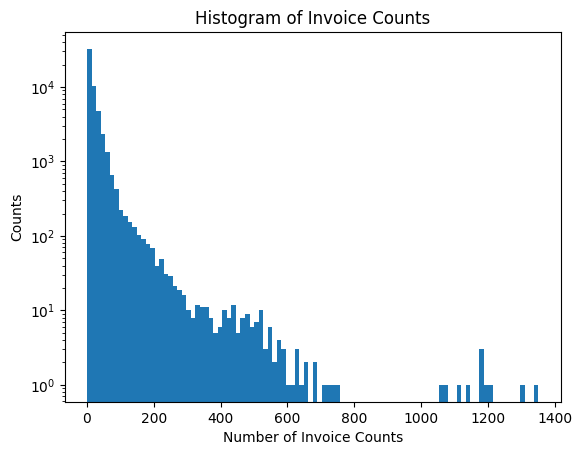

In [202]:
# Most invoices only have a single transaction line

retail['Invoice'].value_counts().plot(kind='hist', bins=100)
plt.xlabel('Number of Invoice Counts')
plt.ylabel('Counts')
plt.title('Histogram of Invoice Counts')
plt.yscale('log')

**StockCode**  
Product (item) code. A unique 5-digit integral number is assigned to each distinct product. 

In [231]:
# Some stock codes do not contain just five-digits, not sure if these can be removed
retail[~retail['StockCode'].str.contains('\d{5}', case=False)]['Description'].value_counts()

POSTAGE                                2115
DOTCOM POSTAGE                         1444
Manual                                 1426
CARRIAGE                                279
Discount                                177
SAMPLES                                 104
Bank Charges                             96
nan                                      62
Adjustment by john on 26/01/2010 16      38
MISO PRETTY  GUM                         30
Dotcomgiftshop Gift Voucher £20.00       26
Adjustment by john on 26/01/2010 17      26
Dotcomgiftshop Gift Voucher £30.00       24
GIRLS PARTY BAG                          23
BOYS PARTY BAG                           21
PADS TO MATCH ALL CUSHIONS               19
CRUK Commission                          16
SUNJAR LED NIGHT NIGHT LIGHT             15
Dotcomgiftshop Gift Voucher £10.00       14
BOXED GLASS ASHTRAY                      13
 Bank Charges                             6
Dotcomgiftshop Gift Voucher £50.00        6
OOH LA LA DOGS COLLAR           

In [ ]:
# Some stock codes do not contain just five-digits, these can be removed
retail = retail[retail['StockCode'].str.contains('C?\d{5}', case=False)]

In [203]:
counts_and_perc(retail, 'StockCode')

,StockCode,Counts,Percentage %
0,85123A,5829,0.5461
1,22423,4424,0.4145
2,85099B,4216,0.3950
3,21212,3318,0.3109
4,20725,3259,0.3053
...,...,...,...
5300,DCGS0067,1,0.0001
5301,DCGS0066P,1,0.0001
5302,DCGS0071,1,0.0001
5303,DCGS0073,1,0.0001


In [204]:
# Some stock code is for test items, remove those
retail[retail['StockCode'].str.contains('test', case=False)]['StockCode'].value_counts()

TEST001    15
TEST002     2
Name: StockCode, dtype: int64

In [205]:
# Additional data cleaning
retail = retail[~retail['StockCode'].str.contains('test', case=False)].copy()

**Quantity**  
The quantities of each product (item) per transaction.

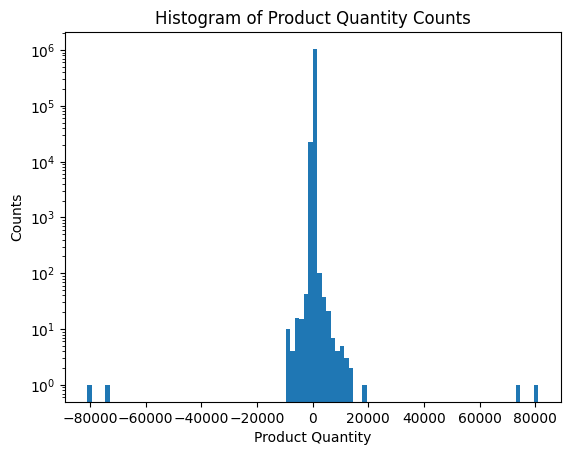

In [206]:
# A decent amount of negative item quantity

retail['Quantity'].plot(kind='hist', bins=100)
plt.xlabel('Product Quantity')
plt.ylabel('Counts')
plt.title('Histogram of Product Quantity Counts')
plt.yscale('log')

In [207]:
# Cancelled Quantity
retail['CancelledQuantity'] = retail.loc[retail['IsCancellation'], 'Quantity']

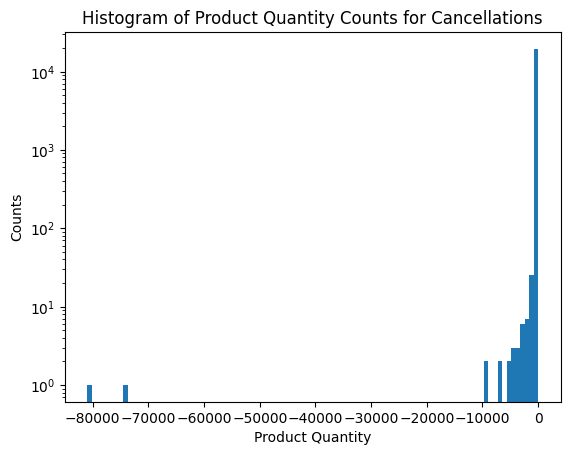

In [208]:
# What are the quantities for cancellations?

retail[retail['IsCancellation']]['Quantity'].plot(kind='hist', bins=100)
plt.xlabel('Product Quantity')
plt.ylabel('Counts')
plt.title('Histogram of Product Quantity Counts for Cancellations')
plt.yscale('log')

In [209]:
# There is one product that was cancelled but has a positive quantity
(retail[retail['IsCancellation']]['Quantity'] > 0).sum()

1

In [210]:
# Add Feature
# Assuming returns are negative quantities without a cancellation
retail['IsReturn'] = ((~retail['IsCancellation']) & (retail['Quantity'] < 0))

In [211]:
# Add Feature on Bulk Orders

In [212]:
counts_and_perc(retail, 'IsReturn')

,IsReturn,Counts,Percentage %
0,False,1063897,99.6761
1,True,3457,0.3239


In [213]:
# All returns are priced as zero 
retail[retail['IsReturn']]['Price'].value_counts()

0.0    3457
Name: Price, dtype: int64

In [214]:
# There are still negative prices with a tag of 'Bad Debt'
# These are outliers and should be removed
retail[(~retail['IsCancellation'])&
       (~retail['IsReturn'])&
       (retail['Price'] < 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,IsCancellation,CancelledQuantity,IsReturn
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,nan,United Kingdom,False,NaN,False
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,nan,United Kingdom,False,NaN,False
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,nan,United Kingdom,False,NaN,False
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,nan,United Kingdom,False,NaN,False
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,nan,United Kingdom,False,NaN,False


In [215]:
adjusted_invoices = retail[(~retail['IsCancellation'])&
                           (~retail['IsReturn'])&
                           (retail['Price'] < 0)]['Invoice']

# Additional data cleaning
retail = retail[~retail['Invoice'].isin(adjusted_invoices)].copy()

In [216]:
# Some stock code items do not look like regular transactions that should be removed

# AmazonFee
print(retail[retail['StockCode']=='AMAZONFEE'].shape)

# Invoice A563185, which is an adjustment
d(retail[retail['Invoice'] == 'A563185'])

# Removing missing Customer ID's (string nan) since these cannot be segmented to begin with
print((retail['Customer ID'] == 'nan').sum())

(43, 11)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,IsCancellation,CancelledQuantity,IsReturn
825443,A563185,B,Adjust bad debt,1,2011-08-12 14:50:00,11062.06,nan,United Kingdom,False,NaN,False


243001


In [217]:
# Removing these same day additionas and cancellations of high quantity
retail[retail['Quantity'].abs() > 50000]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,IsCancellation,CancelledQuantity,IsReturn
587080,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,False,NaN,False
587085,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom,True,-74215.0,False
1065882,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,False,NaN,False
1065883,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446,United Kingdom,True,-80995.0,False


In [218]:
# Additional clean up
retail = retail[(retail['StockCode']!='AMAZONFEE')&
               (retail['Invoice'] != 'A563185')&
               (retail['Quantity'].abs() < 50000)].copy()

**InvoiceDate**  
Invoice date and time. The day and time when a transaction was generated.

In [219]:
# Get more data from the date
retail['InvoiceDateOnly'] = retail['InvoiceDate'].dt.strftime('%F')
retail['InvoiceTimeOnly'] = retail['InvoiceDate'].dt.strftime('%H:%M')

In [220]:
# Higher sales during holiday days, October to December?
# Mark holiday sales
retail['HolidayOrder'] = retail.loc[pd.to_datetime(retail['InvoiceDateOnly']).dt.strftime('%m').isin(['10','11','12']), 'Invoice']
retail['HolidayQuantity'] = retail.loc[pd.to_datetime(retail['InvoiceDateOnly']).dt.strftime('%m').isin(['10','11','12']), 'Quantity']

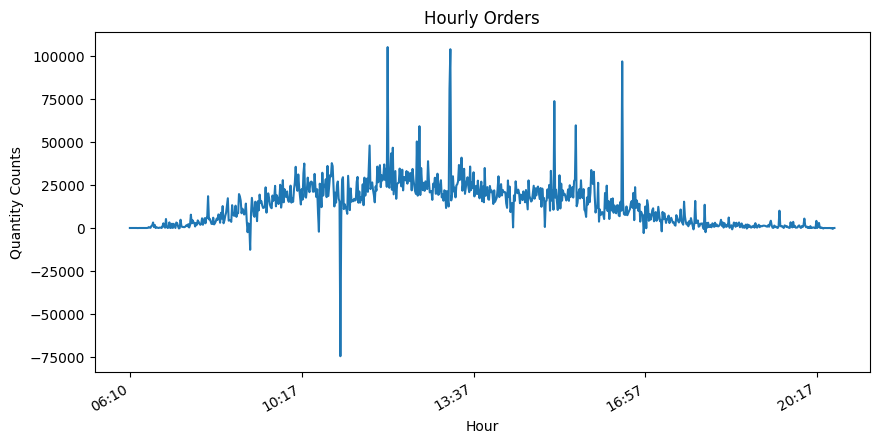

In [221]:
fig, ax = plt.subplots(figsize=(10, 5))
retail.groupby('InvoiceTimeOnly')['Quantity'].sum().sort_index().plot()
plt.xlabel('Hour')
plt.ylabel('Quantity Counts')
plt.title('Hourly Orders')
fig.autofmt_xdate()
#plt.yscale('log')

(0.0, 132723.45)

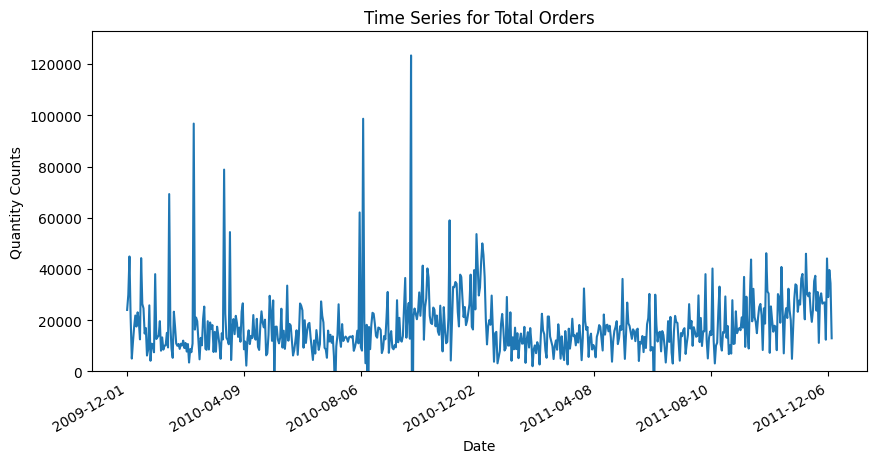

In [222]:
fig, ax = plt.subplots(figsize=(10, 5))
retail.groupby('InvoiceDateOnly')['Quantity'].sum().sort_index().plot()
plt.xlabel('Date')
plt.ylabel('Quantity Counts')
plt.title('Time Series for Total Orders')
fig.autofmt_xdate()
plt.ylim(bottom=0)

In [223]:
retail['HolidayQuantity'] = retail['HolidayQuantity'].fillna(np.NaN)

In [225]:
retail['InvoiceDateOnly'].min()

'2009-12-01'

(0.0, 229.4)

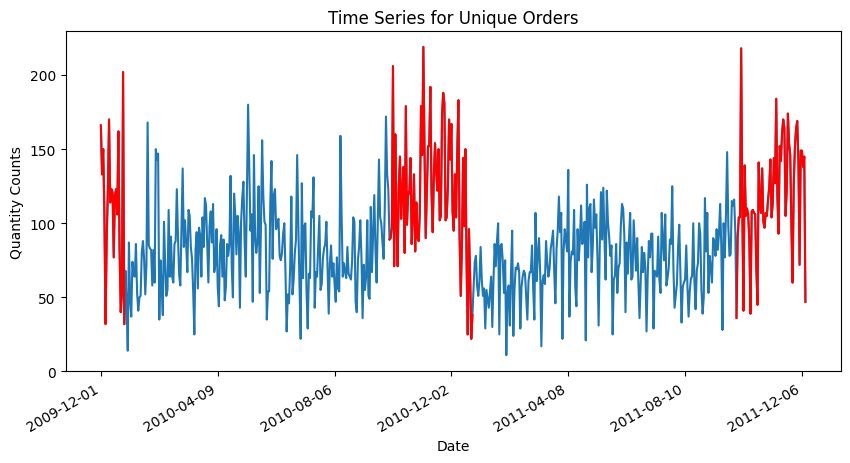

In [224]:
fig, ax = plt.subplots(figsize=(10, 5))
retail.groupby('InvoiceDateOnly')['Invoice'].nunique().sort_index().plot()
# Higher sales during holiday days, October to December?
retail.groupby('InvoiceDateOnly')['HolidayOrder'].nunique().sort_index()\
        .replace({0:np.NaN}).plot(color='r', ax=ax)
plt.xlabel('Date')
plt.ylabel('Quantity Counts')
plt.title('Time Series for Unique Orders')
fig.autofmt_xdate()
plt.ylim(bottom=0)

**Price**  
Unit price.  Product price per unit in pounds (£).

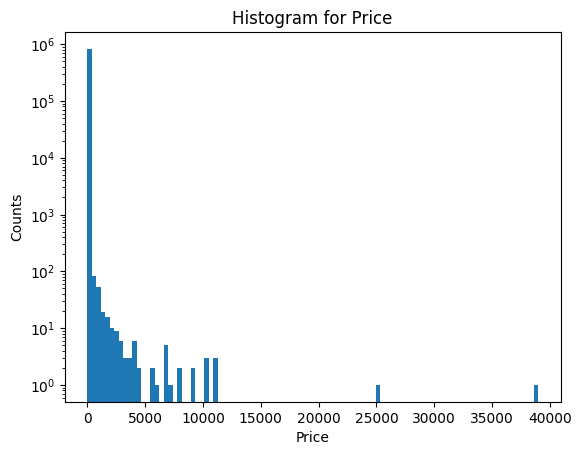

In [155]:
retail['Price'].plot(kind='hist', bins=100)
plt.xlabel('Price')
plt.ylabel('Counts')
plt.title('Histogram for Price')
plt.yscale('log')

In [156]:
# Add feature, total spent per invoice
retail['InvoiceTotal'] = retail['Price']*retail['Quantity']

**Customer ID**  
Customer number.  A unique 5-digit integral number is assigned to each customer

In [157]:
# A decent number of nukk customer guids
counts_and_perc(retail, 'Customer ID')

,Customer ID,Counts,Percentage %
0,17841,13097,1.5888
1,14911,11613,1.4088
2,12748,7307,0.8864
3,14606,6709,0.8139
4,14096,5128,0.6221
...,...,...,...
5935,15896,1,0.0001
5936,13100,1,0.0001
5937,13409,1,0.0001
5938,13401,1,0.0001


In [30]:
# Correct the nan string to null
retail['Customer ID'] = retail['Customer ID'].apply(lambda x: None if x == 'nan' else x)

In [35]:
# It isn't cancelled orders missing the valued
retail[retail['Customer ID'].isna()]['IsCancellation'].value_counts()

False    242257
True        750
Name: IsCancellation, dtype: int64

In [159]:
# No duplicate invoices for missing customers
retail.assign(MissingCustomerID = retail['Customer ID'].isna())\
        .groupby('Invoice')['MissingCustomerID'].nunique().value_counts()

1    44856
Name: MissingCustomerID, dtype: int64

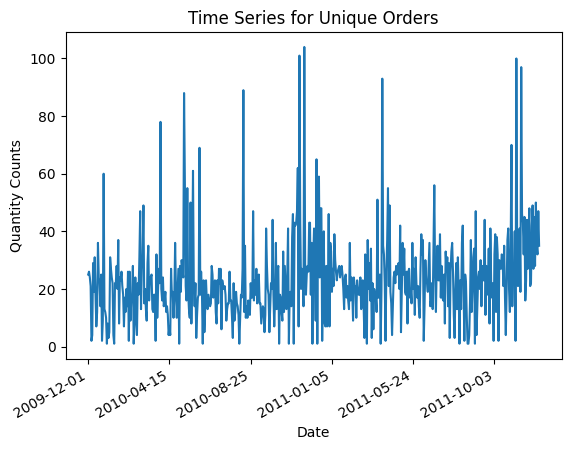

In [33]:
# The null ID's are consistent throughout
fig, ax = plt.subplots() 
retail[retail['Customer ID'].isna()].groupby('InvoiceDateOnly')['Quantity'].nunique().sort_index().plot()
plt.xlabel('Date')
plt.ylabel('Quantity Counts')
plt.title('Time Series for Unique Orders')
fig.autofmt_xdate()

In [ ]:
# Recommend removing NaN customer ids
retail = retail[retail['Customer ID'].notna()]

**Country**  
Country name. The name of the country where a customer resides.

In [160]:
# Most sales are in the UK as expected
counts_and_perc(retail, 'Country')

,Country,Counts,Percentage %
0,United Kingdom,741281,89.9237
1,Germany,17624,2.1379
2,EIRE,16195,1.9646
3,France,14202,1.7228
4,Netherlands,5140,0.6235
5,Spain,3811,0.4623
6,Belgium,3123,0.3788
7,Switzerland,3064,0.3717
8,Portugal,2504,0.3038
9,Australia,1913,0.2321


In [167]:
# Add Feature
retail['ForeignOrder'] = retail['Country'] != 'United Kingdom'

In [168]:
# Save a post EDA copy so the new columns can be used
retail.reset_index(drop=True).to_parquet('retail_post_eda.parquet')